In [1]:

import os
import pickle
import numpy as np
from PIL import Image
import trimesh
import open3d
import matplotlib.pyplot as plt
import cv2

import torch
from torch.utils.data import DataLoader

from pose_estimation.icp import icp
from pose_estimation import PoseData, PoseDataNPZ, PoseDataNPZTorch, COLOR_PALETTE
from pose_estimation.utils import back_project, show_points, compare_points, compute_rre, compute_rte, \
    crop_and_resize, crop_and_resize_multiple

WORKDIR = f"{os.getcwd()}/.."
DATA_FOLDER = os.path.join(WORKDIR, "data_folder")

MODELS_PATH = os.path.join(DATA_FOLDER, "models")
TRAIN_PATH = os.path.join(DATA_FOLDER, "training_data")
TEST_PATH = os.path.join(DATA_FOLDER, "testing_data")

TRAIN_NPZ_PATH = os.path.join(DATA_FOLDER, "dataset_npz")
TEST_NPZ_PATH = os.path.join(DATA_FOLDER, "dataset_npz_test")


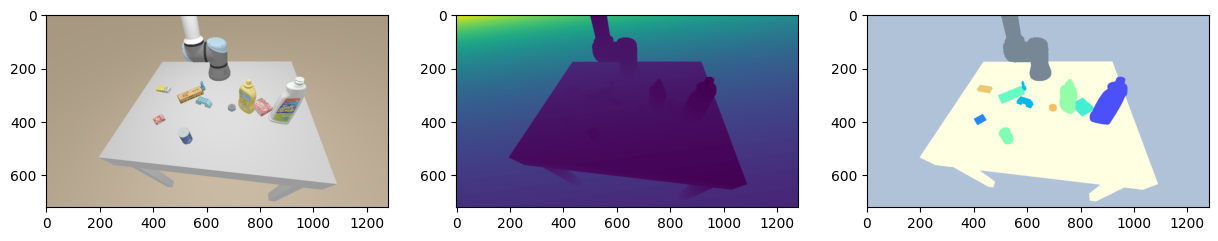

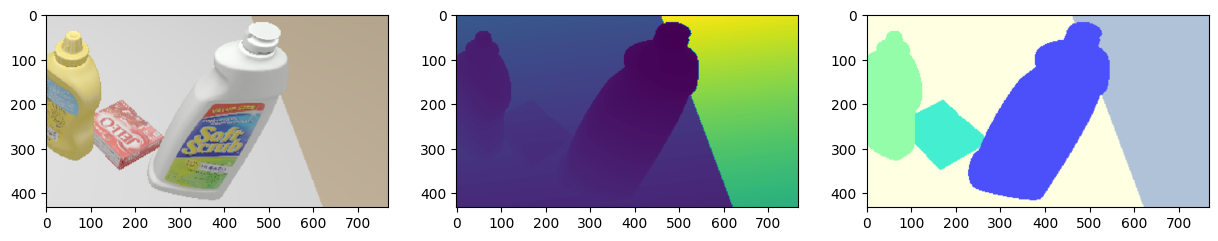

In [2]:

data = PoseData(TRAIN_PATH, MODELS_PATH)

scene = data[2, 1, 1]
rgb = scene["color"]()
depth = scene["depth"]()
label = scene["label"]()
meta = scene["meta"]

plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(rgb)
plt.subplot(1, 3, 2)
plt.imshow(depth)
plt.subplot(1, 3, 3)
plt.imshow(COLOR_PALETTE[label])  # draw colorful segmentation

mask = label == np.unique(label)[0]
target_size = (432, 768)
margin = 8
aspect_ratio = True
mask_fill = False

(rgb_cr, depth_cr, label_cr, mask_cr), scale, translate = crop_and_resize_multiple(
    (rgb, depth, COLOR_PALETTE[label], mask), mask, target_size=target_size, margin=margin, 
    aspect_ratio=aspect_ratio, mask_fill=mask_fill)

plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(rgb_cr)
plt.subplot(1, 3, 2)
plt.imshow(depth_cr)
plt.subplot(1, 3, 3)
plt.imshow(label_cr)  # draw colorful segmentation


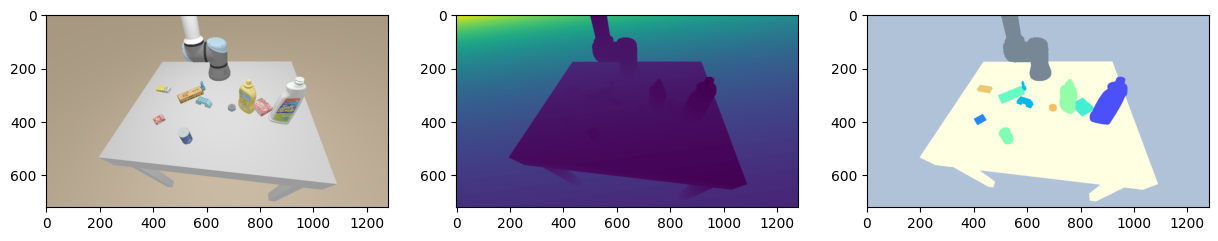

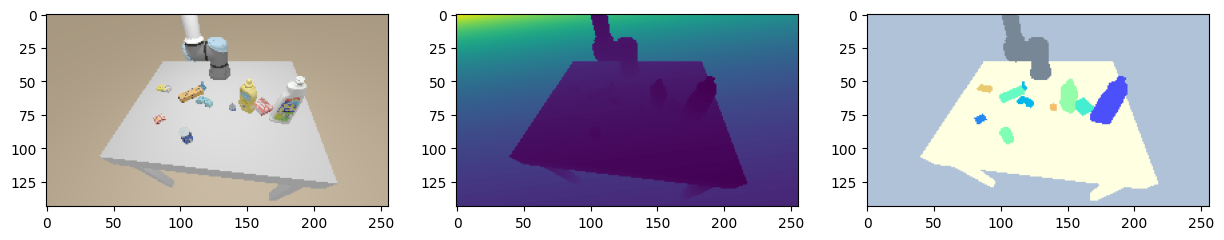

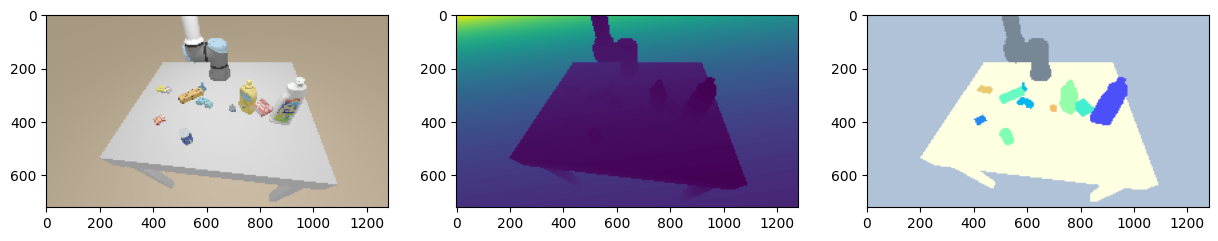

In [4]:
data = PoseData(TRAIN_PATH, MODELS_PATH)

scene = data[2, 1, 1]
rgb = scene["color"]()
depth = scene["depth"]()
label = scene["label"]()
meta = scene["meta"]

ORIGINAL = label.shape[-1], label.shape[-2]
RESIZE = (256, 144)

plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(rgb)
plt.subplot(1, 3, 2)
plt.imshow(depth)
plt.subplot(1, 3, 3)
plt.imshow(COLOR_PALETTE[label])  # draw colorful segmentation

rgb2 = cv2.resize(rgb, RESIZE, interpolation=cv2.INTER_NEAREST)
depth2 = cv2.resize(depth, RESIZE, interpolation=cv2.INTER_NEAREST)
label2 = cv2.resize(label, RESIZE, interpolation=cv2.INTER_NEAREST)

plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(rgb2)
plt.subplot(1, 3, 2)
plt.imshow(depth2)
plt.subplot(1, 3, 3)
plt.imshow(COLOR_PALETTE[label2])  # draw colorful segmentation

rgb3 = cv2.resize(rgb2, ORIGINAL, interpolation=cv2.INTER_NEAREST)
depth3 = cv2.resize(depth2, ORIGINAL, interpolation=cv2.INTER_NEAREST)
label3 = cv2.resize(label2, ORIGINAL, interpolation=cv2.INTER_NEAREST)

plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(rgb3)
plt.subplot(1, 3, 2)
plt.imshow(depth3)
plt.subplot(1, 3, 3)
plt.imshow(COLOR_PALETTE[label3])  # draw colorful segmentation


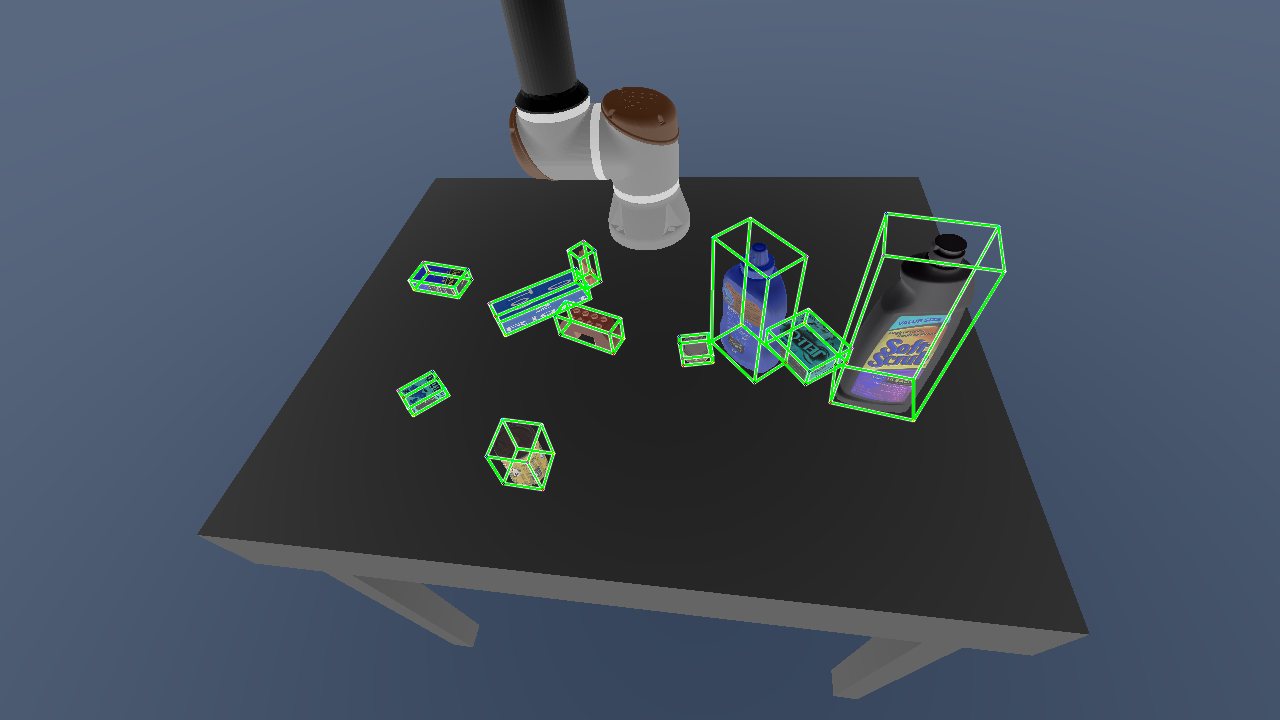

In [ ]:
from pose_estimation import draw_projected_box3d

poses_world = np.array([meta['poses_world'][idx] for idx in meta['object_ids']])
box_sizes = np.array([meta['extents'][idx] * meta['scales'][idx] for idx in meta['object_ids']])

boxed_image = np.array(rgb)
for i in range(len(poses_world)):
    draw_projected_box3d(
        boxed_image, poses_world[i][:3,3], box_sizes[i], poses_world[i][:3, :3], meta['extrinsic'], meta['intrinsic'],
        thickness=2)

Image.fromarray((boxed_image * 255).astype(np.uint8))
